<h1>Indholdsfortegnelse<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot, os, pickle

In [11]:
N_data = 1 * 10 ** 6
features = "v0_chi2 v0_py1 v0_phi1 v0_px1 v0_px v0_px2 v0_phi2 v0_py \
v0_py2 pv0_y pv0_x pv0_z v0_z v0_rxyErr v0_rxy a0xy \
a0 cosTheta v0_x ntrk_pv0 v0_y v0_ks_mass".split(" ")

# features = "v0_chi2, v0_px1, v0_phi1, v0_py1, v0_py,v0_py2, v0_phi2, v0_px2, v0_px, cosTheta, a0xy, a0, v0y, v0x, v0rxyv0rxyErr, v0z, pv0z, pv0y, ntrkpv0, pv0x

In [12]:
data_path = "../../Data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
data_file = uproot.open(data_path)
data_tree = data_file['tree']

df = data_tree.pandas.df(features, entrystop = N_data).sample(3000)

In [ ]:
from scipy.spatial.distance import squareform

In [ ]:
overwrite = False

if "MIC_matrix.dat" not in os.listdir() or overwrite == True: 
    from minepy import pstats
    MIC_corr_matrix = pstats(df.T)
    MIC_corr_matrix = squareform(MIC_corr_matrix[1])
    mic_df = pd.DataFrame(MIC_corr_matrix)
    mic_df.columns = features
    mic_df.to_pickle("MIC_matrix.dat")
else:
    mic_df = pd.read_pickle("MIC_matrix.dat")

In [ ]:
from scipy.cluster.hierarchy import linkage, leaves_list, optimal_leaf_ordering, fcluster
cols_sort = features[:-1]
mat = mic_df.iloc[:-1, :-1]

dist = np.array(1 - mat)
for i in range(dist.shape[0]):
    dist[i, i] = 0

dist = squareform(dist)

Z = linkage(dist, method = "single", optimal_ordering = True)
sort_ind = np.append(leaves_list(optimal_leaf_ordering(Z, dist)), -1)
# sort_ind.append(-1)

cols_sort = np.array(features)[sort_ind]
sorted_mat = np.array(mic_df)[:, sort_ind]
sorted_mat = sorted_mat[sort_ind, :]

label = fcluster(Z, 0.8, criterion = 'distance')[sort_ind]
# cuts = np.arange(len(label))[(label - np.roll(label, 1) == 1)]
# cuts = np.hstack([0] + list(cuts) + [len(label)])
cuts = [0, 1,  10, len(label) - 1, len(label)]

# cuts = [0, 16, len(label)]

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
show = ax.imshow(sorted_mat * 100, vmin = 0, vmax = 100) 
cols = df.columns

ax.set_xticks(np.arange(len(cols_sort)))
ax.set_xticklabels(cols_sort, rotation = 90)
ax.set_yticks(np.arange(len(cols_sort)))
ax.set_yticklabels(cols_sort)
ax.tick_params(axis = 'x', bottom = False, top = True, labelbottom = False, labeltop = True)

cbar = fig.colorbar(show)
cbar.ax.set_ylabel("MIC (multiplied with 100)")

for i in range(sorted_mat.shape[1]):
    for j in range(sorted_mat.shape[0]):
        text = ax.text(j, i, int(np.array(sorted_mat * 100)[i, j]),
                       ha="center", va="center", color="w", fontsize = 8)


for line in cuts[1:-1]:#np.arange(len(label))[(label - np.roll(label, 1) == 1)] - 0.5:
        ax.hlines(line - 0.5, -0.5, len(sort_ind) - .5, color = 'white', linestyle = 'dashed')
        ax.vlines(line - 0.5, -0.5, len(sort_ind) - .5, color = 'white', linestyle = 'dashed')

fig.suptitle("Maximum Information Coefficient of parameters", fontsize = 18)
        
        
fig.tight_layout(rect = (0, 0, 1, 0.95))

# fig.savefig("../figures/Maximal_information_coefficient_seperated.pdf")

In [ ]:
features1 = cols_sort[1:10]

features2 = np.append(cols_sort[10:-1], cols_sort[0])

mass = cols_sort[-1]

true = ["trueKs"]

In [13]:
features1 = "v0_chi2, v0_px1, v0_phi1, v0_py1, v0_py, v0_py2, v0_phi2, v0_px2, v0_px".split(", ")
features2 = "cosTheta, a0xy, a0, v0_y, v0_x, v0_rxy, v0_rxyErr, v0_z, pv0_z, pv0_y, ntrk_pv0, pv0_x".split(", ")
mass = ["v0_ks_mass"]
true = ["trueKs"]

In [14]:
Ndata = 10**6
test_ratio = 0.2

df1 = data_tree.pandas.df(features1, entrystop = Ndata)
df2 = data_tree.pandas.df(features2, entrystart = Ndata, entrystop = 2 * Ndata).reset_index(drop = True)

mass1 = data_tree.pandas.df(mass, entrystop = Ndata)
mass2 = data_tree.pandas.df(mass, entrystart = Ndata, entrystop = 2 * Ndata).reset_index(drop = True)

true1 = data_tree.pandas.df(true, entrystop = Ndata)
true2 = data_tree.pandas.df(true, entrystart = Ndata, entrystop = 2 * Ndata).reset_index(drop = True)

from sklearn.model_selection import train_test_split
df1_train, df1_test, mass1_train, mass1_test, true1_train, true1_test = train_test_split(df1, mass1, true1, test_size = test_ratio)
df2_train, df2_test, mass2_train, mass2_test, true2_train, true2_test = train_test_split(df2, mass2, true2, test_size = test_ratio)

In [15]:
mean, sig = 498.26, 7.005

from xgboost import XGBClassifier as LGBMClassifier

# Apply range
mass = mass1_train[(mass1_train > 400) & (mass1_train < 600)].dropna()

pseudo_true = mass[abs(mass - mean) <  sig].dropna()

am = len(pseudo_true)

# True false
low_false = mass[(mass  + 7 * sig < mean)|(mass  + 10 * sig > mean)].dropna().sample(am)
high_false = mass[(mass  - 10 * sig > mean)|(mass  - 7 * sig < mean)].dropna().sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

target1 = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target1.loc[pseudo_true.index] = 1

model1 = LGBMClassifier()
model1.fit(df1_train.loc[target1.index, :], target1.astype(bool))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [16]:
# Apply range
mass = mass2_train[(mass2_train > 400) & (mass2_train < 600)].dropna()

pseudo_true = mass[abs(mass - mean) <  sig].dropna()

am = len(pseudo_true)

# True false
low_false = mass[(mass  + 10 * sig < mean)|(mass  + 15 * sig > mean)].dropna().sample(am)
high_false = mass[(mass  - 15 * sig > mean)|(mass  - 10 * sig < mean)].dropna().sample(am)

# Make df
indicies = pd.concat([pseudo_true, low_false, high_false]).index

target2 = pd.Series(np.zeros(len(indicies), dtype = int), indicies, dtype = bool)
target2.loc[pseudo_true.index] = 1

model2 = LGBMClassifier()
model2.fit(df2_train.loc[target2.index, :], target2.astype(bool))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
import sys
sys.path.append("../py_files")
import Jonas_homemade as f
import importlib
from ExternalFunctions import nice_string_output, add_text_to_ax
from sklearn.metrics import roc_curve, roc_auc_score


importlib.reload(f)

<module 'Jonas_homemade' from '../py_files/Jonas_homemade.py'>

In [18]:
# fig, ax = plt.subplots(ncols = 3, figsize = (12, 6))

# probs2 = model2.predict_proba(df2_test)
# from scipy.special import logit
# # ax[2].hist(logit(probs2[:, 0]))

# auc_est, cuts, rest_x, rest_y = f.roc_curve_data(mass2_test, probs2[:, 0], ax_roc = ax[0], ax_fits = ax[1], Npoints = 25, verbose = False, ax_hist = ax[2])

# x, y, _ = roc_curve(true2_test, probs2[:, 0])
# auc_true = roc_auc_score(true2_test, probs2[:, 0])

# fig.suptitle(f"Model using: {', '.join(features2)}", fontsize = 14)

# d = {"Estimated AUC:": 1 + auc_est, \
#      "True AUC:":      1 - auc_true}

# add_text_to_ax(0.4, 0.6, nice_string_output(d,extra_spacing = 3), ax = ax[0], fontsize = 9)

# ax[0].plot(y, x, '--')
# ax[2].set_yscale('log')

# ax[0].set(xlabel = "False Positive Rate", ylabel = "True Positve Rate")
# ax[1].set(xlabel = "k-short mass", ylabel = "frequency")
# ax[2].set(xlabel = "logit(probability)", ylabel = "frequency")


# fig.tight_layout(rect = (0, 0, 1, 0.95))

# fig.savefig("../figures/Model_1_uncorr.pdf")

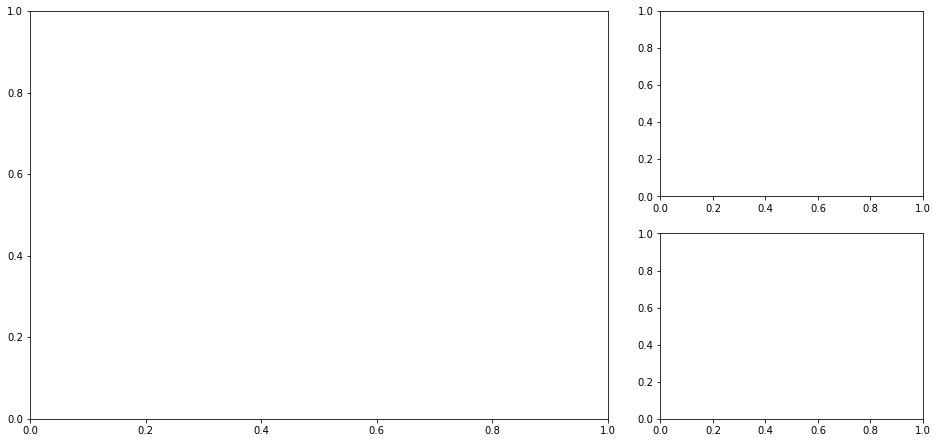

In [46]:
fig = plt.figure(figsize = (16,7.5))
gs = fig.add_gridspec(2, 3)

ax_roc = fig.add_subplot(gs[:, :2])



ax_method = fig.add_subplot(gs[1, 2])


ax_probs = fig.add_subplot(gs[0, 2])



In [47]:
# fig, ax = plt.subplots(ncols = 3, figsize = (12, 6))

probs1 = model1.predict_proba(df1_test)
from scipy.special import logit


auc_est1, cuts, rest_x, rest_y = f.roc_curve_data(mass1_test,  probs1[:, 1], ax_roc = ax_roc, ax_fits = ax_method, Npoints = 15, \
                 plimit = 0, verbose = True, ax_hist = ax_probs)

from sklearn.metrics import roc_curve, roc_auc_score


# ax_roc.text()


probs2 = model2.predict_proba(df2_test)
from scipy.special import logit
# ax[2].hist(logit(probs2[:, 0]))

auc_est2, cuts, rest_x, rest_y = f.roc_curve_data(mass2_test, probs2[:, 1], ax_roc = ax_roc, ax_fits = None, Npoints = 15, verbose = True, ax_hist = None, plimit = 0)





Completed fit with Chi2: 95.6, p-val: 0.351 and the total amount of signal 17090 +/- 264, background: 182910
Completed fit with Chi2: 89.7, p-val: 0.519 and the total amount of signal 11619 +/- 288, background: 175049
Completed fit with Chi2: 84.5, p-val: 0.672 and the total amount of signal 7692 +/- 0, background: 165643
Completed fit with Chi2: 91.9, p-val: 0.454 and the total amount of signal 4751 +/- 208, background: 155249
Completed fit with Chi2: 92.1, p-val: 0.448 and the total amount of signal 2847 +/- 115, background: 143820
Completed fit with Chi2: 89.3, p-val: 0.531 and the total amount of signal 1669 +/- 201, background: 131665
Completed fit with Chi2: 98.2, p-val: 0.285 and the total amount of signal 816 +/- 121, background: 119185
Completed fit with Chi2: 103.6, p-val: 0.173 and the total amount of signal 371 +/- 50, background: 106296
Completed fit with Chi2: 109.4, p-val: 0.092 and the total amount of signal 159 +/- 12, background: 93175
Completed fit with Chi2: 120.3, 

In [48]:
x, y, _ = roc_curve(true1_test, probs1[:, 1])
auc_true1 = roc_auc_score(true1_test, probs1[:, 1])

ax_roc.plot(x, y, 'g--', label = "True ML1 ROC")
ax_probs.set_yscale('log')

In [49]:
x, y, _ = roc_curve(true2_test, probs2[:, 1])
auc_true2 = roc_auc_score(true2_test, probs2[:, 1])



ax_roc.plot(x, y, 'b--', label = "True ML2 ROC")


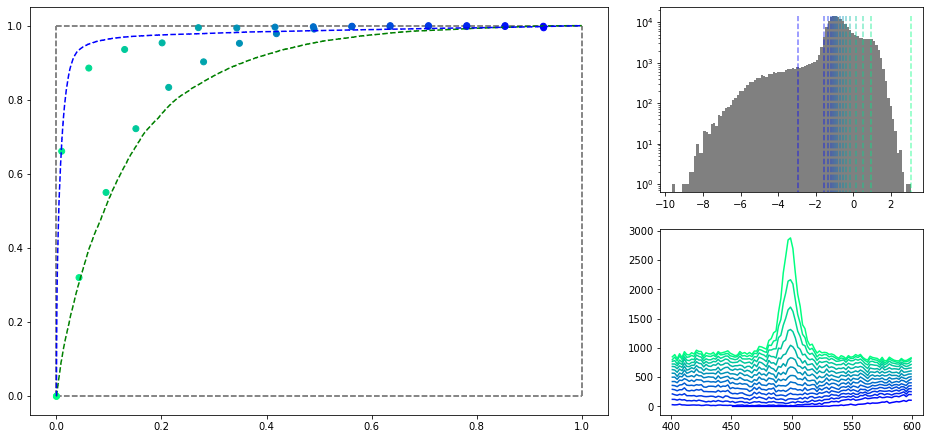

In [50]:
fig

In [51]:

textstr = '\n'.join((
    r"ML1",
    f"estimate: {1 - auc_est1:.3f}",
    f"truth:       {auc_true1:.3f}",
    r" ",
    r"ML2",
    f"estimate: {1 - auc_est2:.3f}",
    f"truth:       {auc_true2:.3f}"))

props = dict(boxstyle='round', facecolor = "white", alpha = 0.25)


ax_roc.text(0.7, 0.23, textstr, transform=ax_roc.transAxes, fontsize=18, bbox=props)

ax_roc.set(xlim = (-0.05, 1.05), ylim = (-0.05, 1.05))


[(-0.05, 1.05), (-0.05, 1.05)]

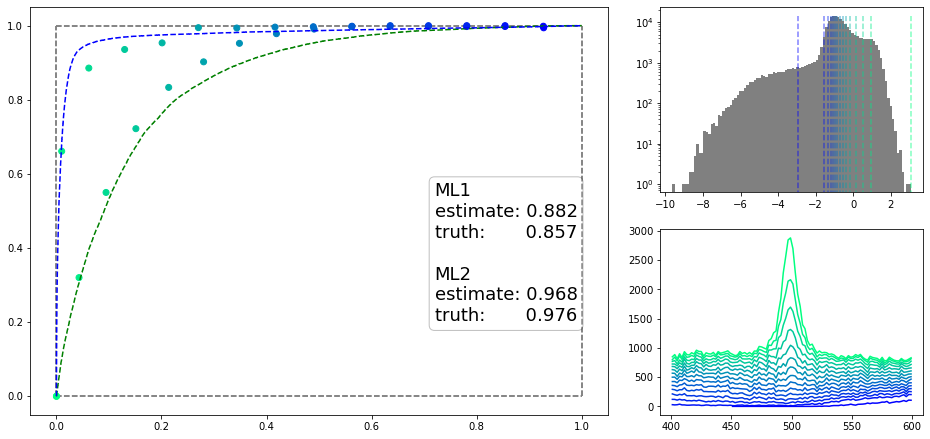

In [52]:
fig

In [53]:
ax_roc.set(title = "ROC-Curve Estimate by Fit", xlabel = "False Positive Rate", ylabel = "True Positive Rate")
ax_probs.set(title = "Distribution of Scores ML1", xlabel = "logit(probability)", ylabel = "freq")
ax_method.set(title = "Histogram for each calculated point in ML1", xlabel = "Ks mass [MeV]", ylabel = "freq")

ax_roc.legend(loc = [0.62, 0.05], fontsize = 18)

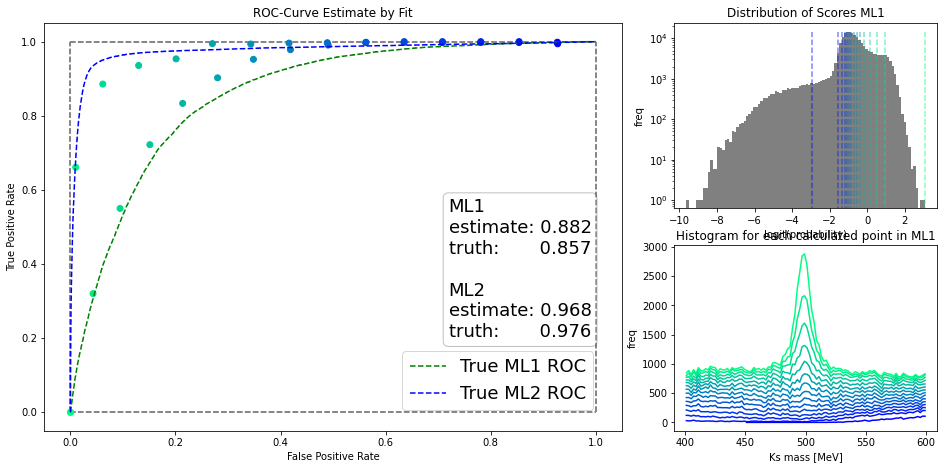

In [54]:
fig

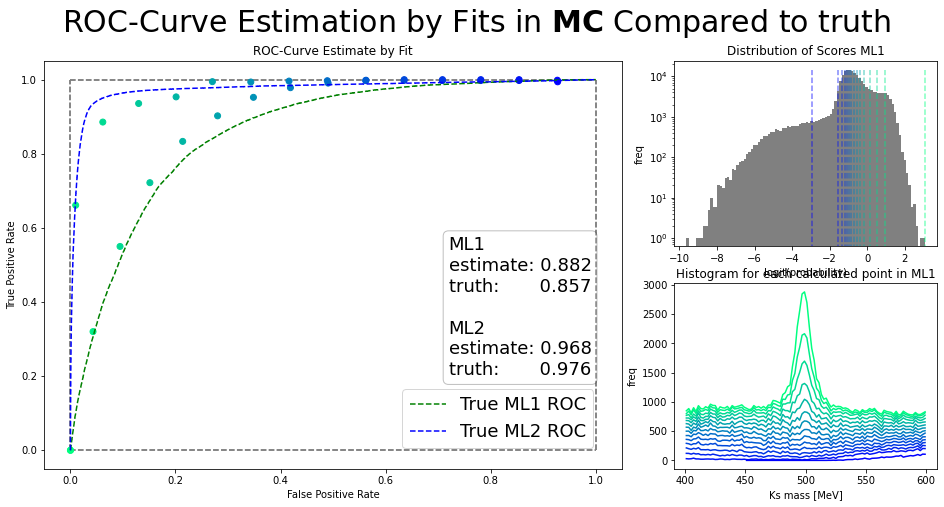

In [55]:
fig.suptitle("ROC-Curve Estimation by Fits in $\\bf{MC}$ Compared to truth", fontsize = 30)
fig

In [56]:
fig.savefig("closure_roc_fit.pdf")